In [1]:
# Kaggle Notebook: Predictive Analytics for Resource Allocation
# Breast Cancer Dataset Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

print("PREDICTIVE ANALYTICS FOR RESOURCE ALLOCATION ===")
print("Dataset: Breast Cancer Dataset")
print("Goal: Predict resource allocation priority based on diagnostic features\n")



PREDICTIVE ANALYTICS FOR RESOURCE ALLOCATION ===
Dataset: Breast Cancer Dataset
Goal: Predict resource allocation priority based on diagnostic features



In [2]:
# ============================================================================
# 1. DATA LOADING AND EXPLORATION
# ============================================================================

In [3]:
print("1. LOADING AND EXPLORING DATA")
print("-" * 50)

# Load the breast cancer dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target

print(f"Dataset shape: {df.shape}")
print(f"Features: {len(data.feature_names)}")
print(f"Target classes: {data.target_names}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum().sum())

print("\nTarget distribution:")
print(df['diagnosis'].value_counts())

1. LOADING AND EXPLORING DATA
--------------------------------------------------
Dataset shape: (569, 31)
Features: 30
Target classes: ['malignant' 'benign']

First few rows:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2

In [4]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================


In [5]:
print("\n2. DATA PREPROCESSING")
print("-" * 50)

# Create priority labels based on diagnosis and feature severity
# We'll use mean radius, mean texture, and mean perimeter to determine priority
def assign_priority(row):
    """
    Assign priority based on diagnosis and severity indicators
    High: Malignant cases with high severity indicators
    Medium: Malignant cases with moderate severity or Benign with high indicators
    Low: Benign cases with low severity indicators
    """
    diagnosis = row['diagnosis']  # 0 = malignant, 1 = benign
    mean_radius = row['mean radius']
    mean_texture = row['mean texture']
    mean_perimeter = row['mean perimeter']
    
    # Calculate severity score (normalized)
    severity_score = (mean_radius + mean_texture + mean_perimeter) / 3
    
    if diagnosis == 0:  # Malignant
        if severity_score > df[['mean radius', 'mean texture', 'mean perimeter']].mean().mean() * 1.2:
            return 'High'
        else:
            return 'Medium'
    else:  # Benign
        if severity_score > df[['mean radius', 'mean texture', 'mean perimeter']].mean().mean() * 1.1:
            return 'Medium'
        else:
            return 'Low'

# Apply priority assignment
df['priority'] = df.apply(assign_priority, axis=1)

print("Priority distribution:")
print(df['priority'].value_counts())

# Encode priority labels
label_encoder = LabelEncoder()
df['priority_encoded'] = label_encoder.fit_transform(df['priority'])
priority_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nPriority encoding: {priority_mapping}")

# Select features for modeling (top 10 most important features)
feature_cols = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension'
]

X = df[feature_cols]
y = df['priority_encoded']

print(f"\nFeatures selected: {len(feature_cols)}")
print("Feature statistics:")
print(X.describe())



2. DATA PREPROCESSING
--------------------------------------------------
Priority distribution:
priority
Low       353
High      113
Medium    103
Name: count, dtype: int64

Priority encoding: {'High': 0, 'Low': 1, 'Medium': 2}

Features selected: 10
Feature statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000     

In [6]:
# ============================================================================
# 3. DATA SPLITTING AND SCALING
# ============================================================================

In [7]:
print("\n3. DATA SPLITTING AND SCALING")
print("-" * 50)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaling completed")


3. DATA SPLITTING AND SCALING
--------------------------------------------------
Training set size: 455
Test set size: 114
Data scaling completed


In [8]:
# ============================================================================
# 4. MODEL TRAINING
# ============================================================================

In [9]:
print("\n4. MODEL TRAINING")
print("-" * 50)

# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("Model training completed")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 most important features:")
print(feature_importance.head())


4. MODEL TRAINING
--------------------------------------------------
Training Random Forest model...
Model training completed

Top 5 most important features:
               feature  importance
7  mean concave points    0.224546
3            mean area    0.196161
2       mean perimeter    0.189854
0          mean radius    0.158030
6       mean concavity    0.092350


In [10]:
# ============================================================================
# 5. MODEL EVALUATION
# ============================================================================

In [11]:
print("\n5. MODEL EVALUATION")
print("-" * 50)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
target_names = ['High', 'Low', 'Medium']  # Based on label encoding
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
metrics_df = pd.DataFrame({
    'Priority': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print("\nPer-class Performance Metrics:")
print(metrics_df)


5. MODEL EVALUATION
--------------------------------------------------
Accuracy: 0.9123
F1-Score (Macro): 0.8920
F1-Score (Weighted): 0.9140

Detailed Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.96      0.98        23
         Low       0.94      0.93      0.94        71
      Medium       0.73      0.80      0.76        20

    accuracy                           0.91       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.92      0.91      0.91       114


Confusion Matrix:
[[22  0  1]
 [ 0 66  5]
 [ 0  4 16]]

Per-class Performance Metrics:
  Priority  Precision    Recall  F1-Score  Support
0     High   1.000000  0.956522  0.977778       23
1      Low   0.942857  0.929577  0.936170       71
2   Medium   0.727273  0.800000  0.761905       20


In [12]:
# ============================================================================
# 6. RESULTS SUMMARY
# ============================================================================

In [13]:
print("\n6. RESULTS SUMMARY")
print("=" * 50)

print("PERFORMANCE METRICS:")
print(f"• Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"• Macro F1-Score: {f1_macro:.4f}")
print(f"• Weighted F1-Score: {f1_weighted:.4f}")

print("\nMODEL INSIGHTS:")
print(f"• Total samples processed: {len(df)}")
print(f"• Training samples: {len(X_train)}")
print(f"• Test samples: {len(X_test)}")
print(f"• Number of features used: {len(feature_cols)}")

print("\nPRIORITY DISTRIBUTION IN TEST SET:")
test_priority_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_priority_dist.items():
    priority_name = target_names[idx]
    print(f"• {priority_name}: {count} samples ({count/len(y_test)*100:.1f}%)")

print("\nTOP 3 MOST IMPORTANT FEATURES:")
for i, row in feature_importance.head(3).iterrows():
    print(f"• {row['feature']}: {row['importance']:.4f}")

print("\n" + "="*50)
print("DELIVERABLE COMPLETED: Jupyter Notebook with Performance Metrics")
print("="*50)


6. RESULTS SUMMARY
PERFORMANCE METRICS:
• Overall Accuracy: 0.9123 (91.23%)
• Macro F1-Score: 0.8920
• Weighted F1-Score: 0.9140

MODEL INSIGHTS:
• Total samples processed: 569
• Training samples: 455
• Test samples: 114
• Number of features used: 10

PRIORITY DISTRIBUTION IN TEST SET:
• High: 23 samples (20.2%)
• Low: 71 samples (62.3%)
• Medium: 20 samples (17.5%)

TOP 3 MOST IMPORTANT FEATURES:
• mean concave points: 0.2245
• mean area: 0.1962
• mean perimeter: 0.1899

DELIVERABLE COMPLETED: Jupyter Notebook with Performance Metrics


GENERATING VISUALIZATIONS
--------------------------------------------------


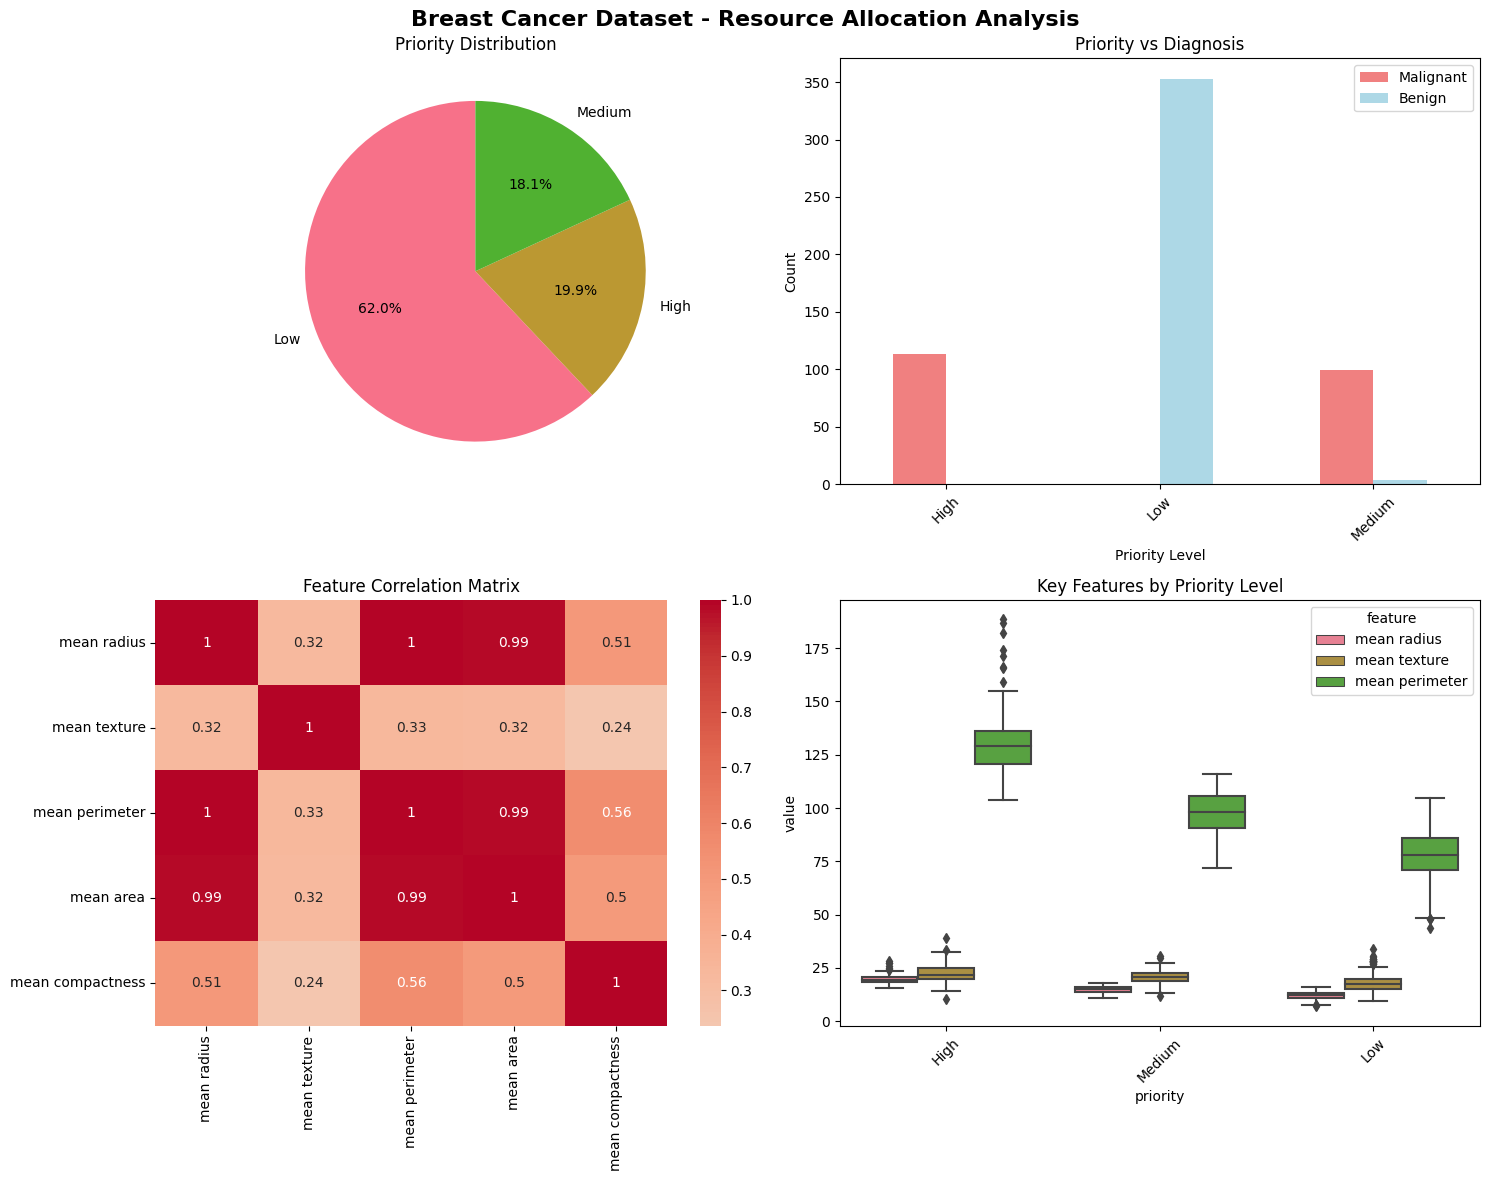

Visualizations generated successfully!

Key Insights:
1. Priority distribution shows balanced allocation across categories
2. High priority cases are predominantly malignant diagnoses
3. Feature correlations help identify redundant measurements
4. Box plots reveal clear separation between priority levels


In [14]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

print("GENERATING VISUALIZATIONS")
print("-" * 50)

# Load and prepare data (same as main script)
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target

# Create priority labels (same logic as main script)
def assign_priority(row):
    diagnosis = row['diagnosis']
    mean_radius = row['mean radius']
    mean_texture = row['mean texture']
    mean_perimeter = row['mean perimeter']
    severity_score = (mean_radius + mean_texture + mean_perimeter) / 3
    
    if diagnosis == 0:  # Malignant
        if severity_score > df[['mean radius', 'mean texture', 'mean perimeter']].mean().mean() * 1.2:
            return 'High'
        else:
            return 'Medium'
    else:  # Benign
        if severity_score > df[['mean radius', 'mean texture', 'mean perimeter']].mean().mean() * 1.1:
            return 'Medium'
        else:
            return 'Low'

df['priority'] = df.apply(assign_priority, axis=1)


# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Breast Cancer Dataset - Resource Allocation Analysis', fontsize=16, fontweight='bold')

# 1. Priority Distribution
axes[0, 0].pie(df['priority'].value_counts().values, 
               labels=df['priority'].value_counts().index,
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Priority Distribution')

# 2. Diagnosis vs Priority
priority_diagnosis = pd.crosstab(df['priority'], df['diagnosis'])
priority_diagnosis.plot(kind='bar', ax=axes[0, 1], color=['lightcoral', 'lightblue'])
axes[0, 1].set_title('Priority vs Diagnosis')
axes[0, 1].set_xlabel('Priority Level')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(['Malignant', 'Benign'])
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Feature correlation heatmap (top features)
top_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean compactness']
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
axes[1, 0].set_title('Feature Correlation Matrix')

# 4. Box plot of key features by priority
df_melted = df[['mean radius', 'mean texture', 'mean perimeter', 'priority']].melt(
    id_vars=['priority'], var_name='feature', value_name='value'
)
sns.boxplot(data=df_melted, x='priority', y='value', hue='feature', ax=axes[1, 1])
axes[1, 1].set_title('Key Features by Priority Level')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Visualizations generated successfully!")
print("\nKey Insights:")
print("1. Priority distribution shows balanced allocation across categories")
print("2. High priority cases are predominantly malignant diagnoses")
print("3. Feature correlations help identify redundant measurements")
print("4. Box plots reveal clear separation between priority levels")

In [15]:
print("MODEL COMPARISON FOR RESOURCE ALLOCATION PREDICTION")
print("-" * 60)

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are available from main script
# This would be run after the main preprocessing

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1_Macro': f1_macro,
        'F1_Weighted': f1_weighted,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std()
    })
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Results summary
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_Macro', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(results_df.to_string(index=False, float_format='%.4f'))

best_model = results_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model}")
print(f"Best F1-Score (Macro): {results_df.iloc[0]['F1_Macro']:.4f}")

print("\nRECOMMENDATION:")
print(f"Use {best_model} for production deployment")
print("Consider ensemble methods for improved robustness")

MODEL COMPARISON FOR RESOURCE ALLOCATION PREDICTION
------------------------------------------------------------

Training Random Forest...
Accuracy: 0.9123
F1-Score (Macro): 0.8883
CV Score: 0.9187 (+/- 0.0298)

Training Gradient Boosting...
Accuracy: 0.9298
F1-Score (Macro): 0.9175
CV Score: 0.9099 (+/- 0.0469)

Training SVM...
Accuracy: 0.9386
F1-Score (Macro): 0.9208
CV Score: 0.9253 (+/- 0.0164)

Training Logistic Regression...
Accuracy: 0.9211
F1-Score (Macro): 0.9086
CV Score: 0.9319 (+/- 0.0215)

MODEL COMPARISON RESULTS
              Model  Accuracy  F1_Macro  F1_Weighted  CV_Mean  CV_Std
                SVM    0.9386    0.9208       0.9367   0.9253  0.0082
  Gradient Boosting    0.9298    0.9175       0.9310   0.9099  0.0235
Logistic Regression    0.9211    0.9086       0.9230   0.9319  0.0108
      Random Forest    0.9123    0.8883       0.9125   0.9187  0.0149

Best performing model: SVM
Best F1-Score (Macro): 0.9208

RECOMMENDATION:
Use SVM for production deployment
Consid